In [1]:
import os
import gc
import time
import traceback
from contextlib import contextmanager
from enum import Enum
from typing import Dict, List, Optional, Tuple

import seaborn as sns
import pandas as pd
# pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
import dask.dataframe as dd

from joblib import delayed, Parallel


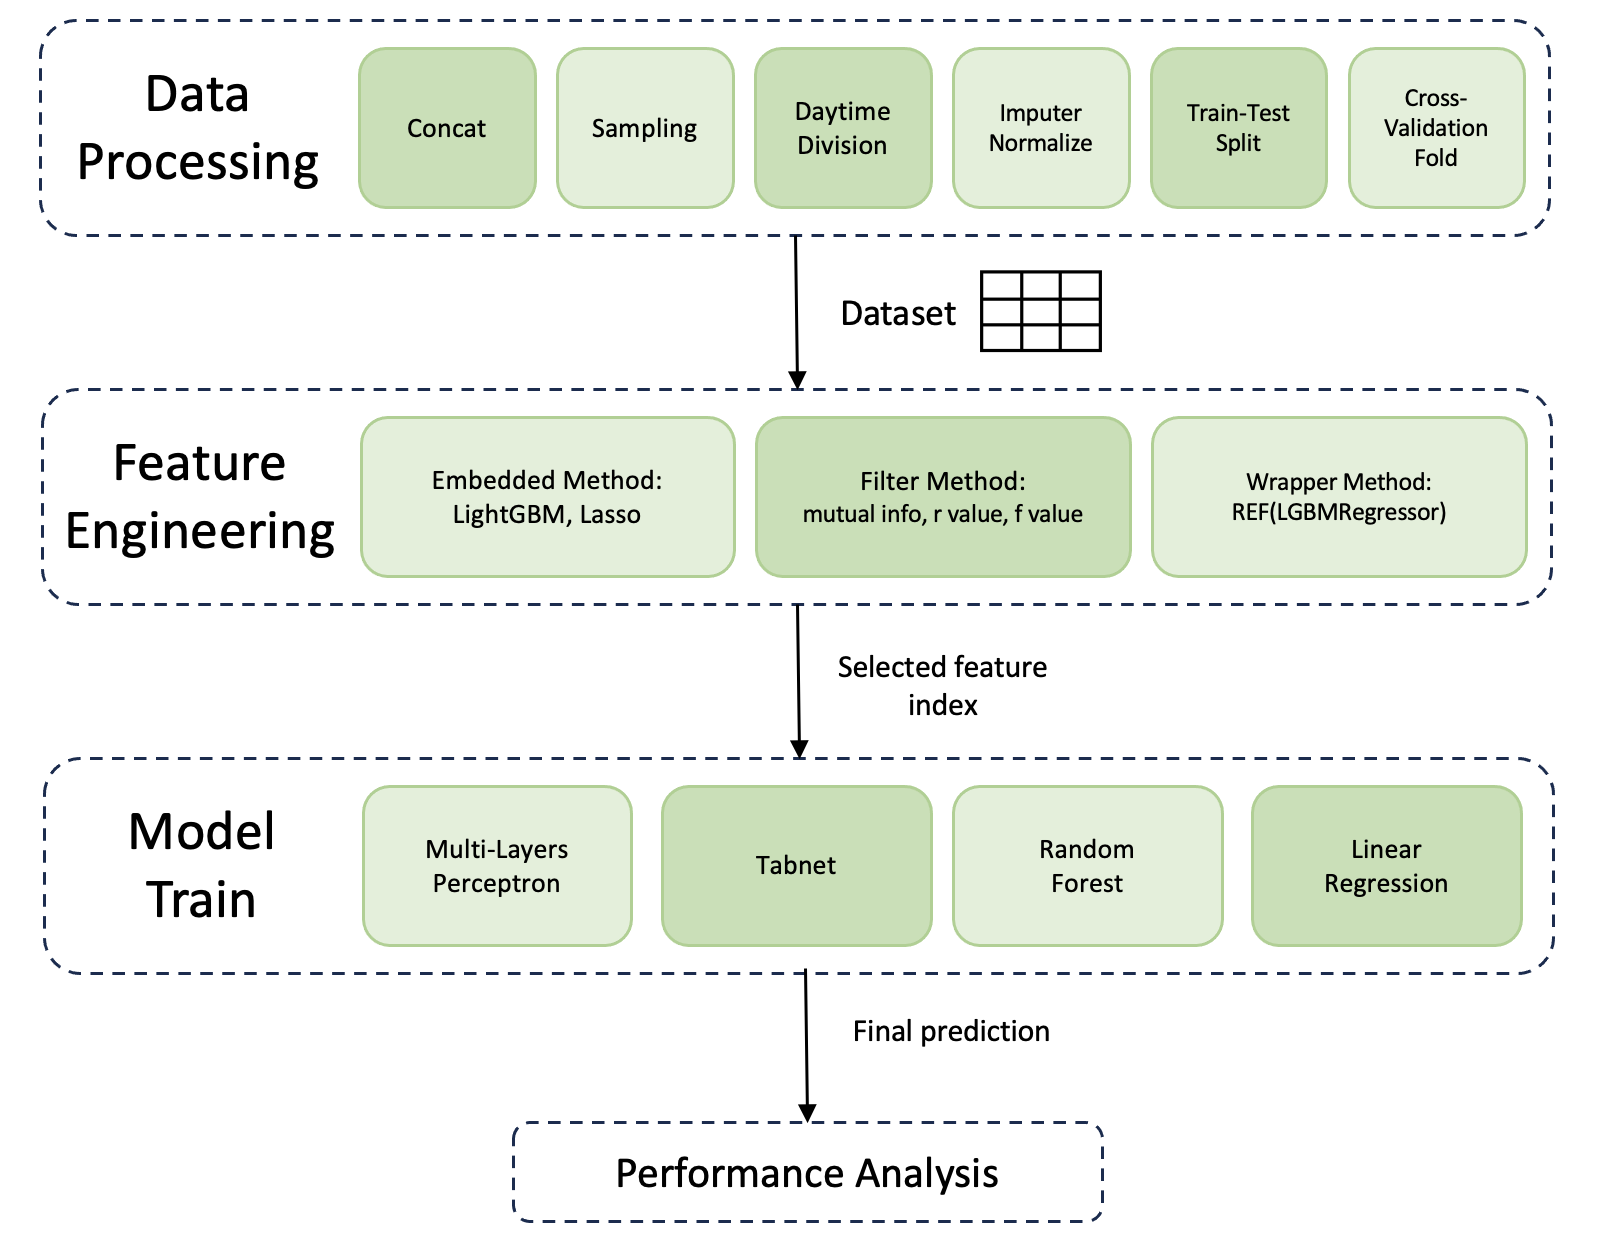

## Constants

In [9]:
DATA_DIR =  '/Users/linyukai/bagging_fin_prediction/'

QUALITY_THRESHOLD = 0.9999
BAD_VALUE = 999999
ROW_SPARSE_THRESHOLD = 0.5

NUM_FEATURE = 375

NUM_FILE = 298

AVG_PARTITION_SIZE = 50

TRY_USE_CACHING = False

MSEC_PER_HOUR = 3600000

In [4]:
@contextmanager
def timer(label: str):
    s = time.perf_counter()
    yield
    timePassing = time.perf_counter() - s
    print(f'{label} {timePassing: .3f}sec')

def print_trace(name: str = ''):
    print(f'ERROR RAISED IN {name or "anonymous"}')
    print(traceback.format_exc())

# Data Processing

## Concat

In [ ]:
from datetime import datetime

def parse_date_from_filename(filename: str) -> date:
    date_str = filename.split('.')[-3][-8:]
    return datetime.strptime(date_str, '%Y%m%d').date()

def convert_milliseconds_to_time(ms):
    seconds, milliseconds = divmod(ms, 1000)
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}.{int(milliseconds):03}"

def process_parquet(filename: str, do_test: bool = False):
    df = pd.read_parquet(os.path.join(DATA_DIR, 'qr_takehome', filename))
    df['date'] = parse_date_from_filename(filename)

    df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + (df['time'].apply(convert_milliseconds_to_time)))

    df.drop(columns=['sym', 'exch', 'date', 'time'], inplace=True)

    # drop sparse rows
    df = df[df.isna().sum(axis=1) <= NUM_FEATURE * ROW_SPARSE_THRESHOLD]

    # drop bad values
    df = df[~(df == BAD_VALUE).any(axis=1)]

    df.set_index(['datetime'], inplace=True)

    df.fillna(df.shift().rolling(window=3, min_periods=1).mean(), inplace=True)

    # return df.resample('10S').median()
    if not os.path.exists(os.path.join(DATA_DIR, 'processed')):
        os.makedirs(os.path.join(DATA_DIR, 'processed'))
    if not do_test:
        df.resample('10S').median().to_parquet(os.path.join(DATA_DIR, 'processed', 'processed_' + filename))
    else:
        # when forecast on test set, disable the resampling for correct shape
        if not os.path.exists(os.path.join(DATA_DIR, 'test_processed')):
            os.makedirs(os.path.join(DATA_DIR, 'test_processed'))
        df.to_parquet(os.path.join(DATA_DIR, 'test_processed', 'processed_' + filename))

def process_parquet_together(data_dir, do_test=False):
    # use parallel to process data together
    Parallel(n_jobs=-1)(delayed(process_parquet)\
        (filename, do_test) for filename in os.listdir(data_dir) if filename.endswith('.parquet'))

def read_and_concatenate_parquets(data_dir) -> pd.DataFrame:
    # Using Parallel to concat all the dataframe and sort by date
    all_dfs = Parallel(n_jobs=-1)(delayed(pd.read_parquet)\
        (os.path.join(data_dir, filename)) for filename in os.listdir(data_dir) if filename.endswith('.parquet'))

    all_df = pd.concat(all_dfs).sort_values(by=['date','time'])
    all_df.set_index(['date','time'], inplace=True)
    return all_df

def fill_with_last_val(series: pd.Series, window_size: int=3) -> pd.Series:
    # fillna with rolling average of previous 3 days and remain empty if all nan
    return series.fillna(series.shift())

def fillna_by_columns(df: pd.DataFrame) -> pd.DataFrame:
    #fill with last val
    processed_cols = {}

    # Process each numeric column separately
    numeric_cols = [col for col in df.columns if col not in ['date', 'time']]
    for col in numeric_cols:
        processed_cols[col] = fill_with_last_val(df[col])

    # Combine the processed columns back into a DataFrame
    for col in ['date', 'time']:
        if col in df.columns:
            processed_cols[col] = df[col]

    # Create a new DataFrame from the processed columns
    return pd.DataFrame(processed_cols)

In [ ]:
with timer('process parquet'):
    process_parquet_together(os.path.join(DATA_DIR, 'qr_takehome'))

## sampling

Since financial data may not be stable, here we use median of 10 consecutive second datapoints to sample the orginal dataset, which is robust.

## Division

Here we plot out the cross-sectional average of target, finding that the variance would change based on time. This obeys with the consensus in the capital market. Normally, in the morning, traders and investers will trade with higher frequency and volumes, bringing more volitility. Similar phenonmenon is also found when the market is about to close. Relatively, there is a slot with lower volitlity in the daytime.

With this in mind, we split our data into 3 periods, 9:45 to 11:00, 11:00 to 14:00 and 14:00 to 16:00.

/var/folders/8v/r0lk2mbn2k5dgm_pdmv4_8hr0000gn/T/ipykernel_19303/1629382206.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sampled['time'] = df_sampled.index.time


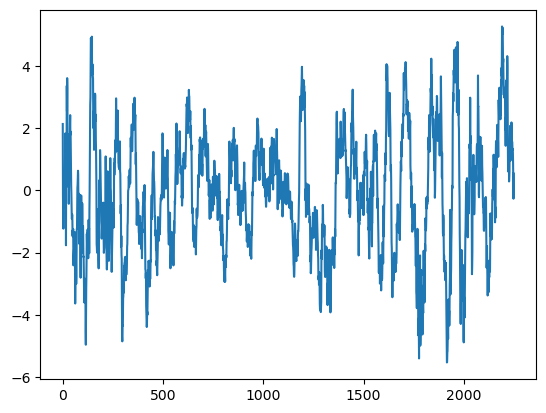

In [ ]:
original_data_dir = os.path.join(DATA_DIR, 'processed')

dfs_sampled = Parallel(n_jobs=-1)(delayed(pd.read_parquet)\
    (os.path.join(original_data_dir, filename)) for j, filename in enumerate(os.listdir(orginal_data_dir)) if not j % 7)

df_sampled = pd.concat(dfs_sampled).sort_values(by=['datetime'])
df_sampled['time'] = df_sampled.index.time

df_sampled_avg = df_sampled.groupby('time').mean().reset_index()
plt.plot(df_sampled_avg.index, df_sampled_avg['Y1'])

In [6]:
def convert_time_to_milliseconds(t):
    return (t.hour * 3600 + t.minute * 60 + t.second) * 1000 + int(t.microsecond / 1000)

def daytime_division(filename: str, periods: List) -> pd.DataFrame:
    # for 9:45 to 11:00, partition should be (9.75, 11)
    # for 11:00 to 14:00, partition should be (11, 14)
    # for 14:00 to 16:00, partition should be (14, 16)
    time_start = periods[0] * MSEC_PER_HOUR
    time_end = periods[1] * MSEC_PER_HOUR
    df = pd.read_parquet(os.path.join(DATA_DIR, 'processed', filename))
    df['time'] = df.index.time
    df['time'] = df['time'].apply(convert_time_to_milliseconds)

    df = df[(time_start < df['time']) & (df['time'] <= time_end)]
    return df

def generate_divided_feather(data_dir: str, periods: List=[9.75, 11, 14, 16], do_test: bool=False):
    # if this is used for testing sesson, the data fetching should be from different path
    test_prefix = 'test_' if do_test else ''

    for i in range(len(periods) - 1):
        dfs = Parallel(n_jobs=-1)(delayed(daytime_division)(filename, periods[i:i+2]) for filename in os.listdir(os.path.join(data_dir, f'{test_prefix}processed')) if filename.endswith('.parquet'))
        df_divided = pd.concat(dfs).sort_values(by=['datetime'])
        df_divided.reset_index(inplace=True)

        if not os.path.exists(os.path.join(data_dir, f'{test_prefix}division')):
            os.makedirs(os.path.join(data_dir, f'{test_prefix}division'))

        df_divided.to_feather(os.path.join(data_dir, f'{test_prefix}division', f'{periods[i]}_{periods[i+1]}.f'))
        del df_divided

        gc.collect()

In [ ]:
with timer('feather_division'):
    # data in each period will be stored in type of feather
    generate_divided_feather(DATA_DIR)

<ipython-input-9-040bd908effc>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_divided.reset_index(inplace=True)
<ipython-input-9-040bd908effc>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_divided.reset_index(inplace=True)
<ipython-input-9-040bd908effc>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = 

feather_division  180.578sec


For each Y of each period, the process is the same. So we should fisrtly set the DATA_LABEL below, e.g. if i = 2, target_label = 1. Then in the further steps, the model is training for Y2 in the 3rd period(14:00 - 16:00). This will also related with the file path where model, plot and prediction are saved.

In [147]:
# adjust for each period
periods = [9.75, 11, 14, 16]
i = 1
target_label = 2
DATA_LABEL = f'{periods[i]}_{periods[i+1]}_Y{target_label}'

try:
    with timer('using cache'):
        df_both = pd.read_feather(os.path.join(DATA_DIR, 'division', f'{periods[i]}_{periods[i+1]}.f'))
except:
    print_trace('using cache')



using cache  0.811sec


In [148]:
with timer('split'):
    if target_label == 1:
        df_y1 = df_both[df_both['Q1']>=0.999].drop(columns=['Y2','Q1','Q2'])
    if target_label == 2:
        df_y2 = df_both[df_both['Q2']>=0.999].drop(columns=['Y1','Q1','Q2'])

split  0.672sec


In [82]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

In [149]:
if target_label == 1:
    X = df_y1.drop(['datetime', 'time', 'Y1'], axis=1)
    y = df_y1['Y1']
if target_label == 2:
    X = df_y2.drop(['datetime', 'time', 'Y2'], axis=1)
    y = df_y2['Y2']

## train_test split

Since we do not have the test set for this project, for a comprehensive machine learning training project, we split our data into train set and test set with ratio of 9:1.

We are modeling on time series financial data, so we should make cross validation of time series version. Typical time series cross validation split is good, but there will arise a issue that for each fold, the size of training set is different. Here we define our version of split method. Where the validation set this fold will overlapped with 1/4 of training set next fold, which make full use of time series and the size of data for each fold is identically the same.

In [150]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split

def overlapping_time_series_split(X, n_splits=5, train_val_ratio=4):
    n_samples = len(X)

    part_size = n_samples // (n_splits * train_val_ratio + 1)

    for i in range(n_splits):

        test_start = (i + 1) * part_size * 4

        test_end = test_start + part_size
        train_start = max(0, test_start - 4 * part_size)
        train_end = test_start

        train_index = np.arange(train_start, train_end)
        test_index = np.arange(test_start, test_end)

        yield train_index, test_index

with timer('train test split'):
    X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy().ravel(), test_size=0.1, shuffle=False)
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.1, shuffle=False)

n_splits = 5
tscv = overlapping_time_series_split(X_train, n_splits)
with timer('make folds'):
    folds = [(train_idx, test_idx) for train_idx, test_idx in tscv]



train test split  1.113sec
make folds  0.001sec


# Metric


Below are all the metric we would use in this project. For training, we use Root Mean Squre Percentage Error(RMSPE) as metric for

In [18]:
!pip install pytorch_tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00


In [112]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from pytorch_tabnet.metrics import Metric
import torch


def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + 1e-4)))))

def rmape(y_true, y_pred):
    # epsilon = .1 if not y_true else 0
    return  np.mean(np.abs(y_true - y_pred) / np.abs(y_true + 1e-4))

def rmspe_torch(y_true, y_pred):
    # Ensure that the division is not by zero
    loss = torch.sqrt(torch.mean(((y_true - y_pred) / (y_true + 1e-4)) ** 2))
    return loss

def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False
def mse(y_true, y_pred):
    return  (np.mean(np.square((y_true - y_pred))))

def mse_torch(y_true, y_pred):
    return  torch.sqrt(torch.mean((y_true - y_pred) ** 2))

def feval_MSE(preds, train_data):
    labels = train_data.get_label()
    return 'MSE', round(mse(y_true = labels, y_pred = preds),5), False

class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score, epsilon=1e-4):
        return np.sqrt(np.mean(np.square((y_true - y_score) / (y_true + epsilon))))

def RMSPELoss_torch(y_pred, y_true, epsilon=1e-4):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / (y_true + epsilon)) ** 2 )).clone()





# Feature Selection

In [86]:
COLUMNS = X.columns

In [88]:
def convert_col_2_pos(Index):
    # convert from col name of pd.DataFrame to index of position for np.darray
    return [COLUMNS.get_loc(col) for col in list(Index)]

We can conclude from the correlation heatmap that the most features are not highly correlated, whether positively or negatively.

heatmap  63.974sec


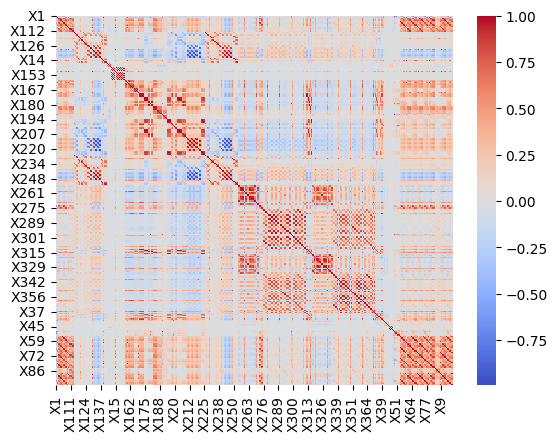

In [137]:
with timer('heatmap'):
    sns.heatmap(X.corr(), cmap='coolwarm')

From the scatter plot of Y1 and Y2, we get to know that the they are highly positivly correlated.

compare Y1 and Y2  0.040sec


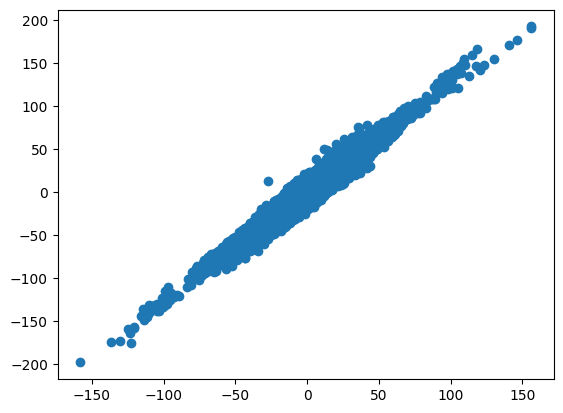

In [24]:
with timer('compare Y1 and Y2'):
    plt.scatter(df_both['Y1'], df_both['Y2'])

For feature selection, there are basically 3 method, embeded method, filter method and wrapper method.

## Embeded Method

I tried Lightgbm and Lasso in this method. For both of them, I will use cross-valitdation to select features. The cross validation split will be implemented in X_train to avoid any information leak to testing session. Each fold have a rank of important features and the final selected features are determined by all folds.

### LightGBM Pruning

In [89]:
import lightgbm as lgb
dataset_lgb = lgb.Dataset(X_train, y_train)

params = {
    'objective': 'regression',
    'verbose': -1,
    'metric': '',
    'reg_alpha': 5,
    'reg_lambda': 5,
    'min_data_in_leaf': 1000,# 1000,
    'max_depth': -1,
    'num_leaves': 64,
    'colsample_bytree': 0.3,
    'learning_rate': .03
}

In [26]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(cvbooster, figsize=(10, 10)):
    raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = cvbooster.boosters[0].feature_name()
    importance_df = pd.DataFrame(data=raw_importances,
                                 columns=feature_name)
    # order by average importance across folds
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    # plot top-n
    PLOT_TOP_N = 50
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [90]:
with timer('lgb.cv'):
    ret = lgb.cv(params, dataset_lgb, num_boost_round=100, folds=folds, #cv,
                feval=feval_RMSPE, stratified=False,
                return_cvbooster=True,#verbose=20,
                # early_stopping_rounds=int(40*0.1/lr)
                )
    print(f"# overall RMSPE: {ret['valid RMSPE-stdv'][-1]}")



# overall RMSPE: 71.90230358076701
lgb.cv  9.387sec


Below is the correlation of top important features, some may have high absolute corr but it is still acceptable since we will pick subset of those features, during which high corr will be considered.

<Axes: >

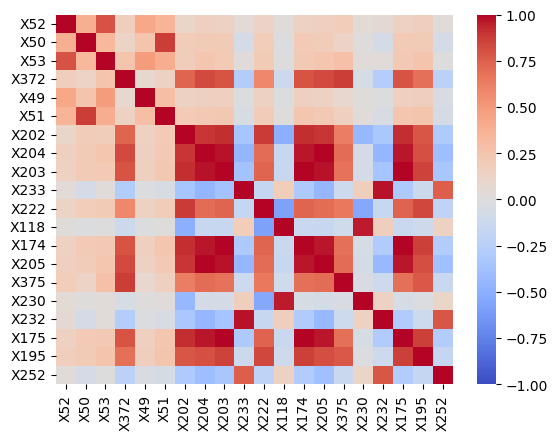

In [91]:
raw_importances = ret['cvbooster'].feature_importance(importance_type='gain')
feature_name = ret['cvbooster'].boosters[0].feature_name()
importance_df = pd.DataFrame(data=raw_importances,columns=feature_name)

# order by average importance across folds
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# plot top-n
plot_top_n = 20
selected_col = sorted_importance_df.columns[:plot_top_n]
selected_X = X[selected_col]
sns.heatmap(selected_X.corr(),annot=False, cmap='coolwarm', vmin=-1)

I generate a plot from result of top important features. Features valuing higher are cosidered more important.

# fold0 MSE: 96.80972869748669
# fold1 MSE: 255.46977375303365
# fold2 MSE: 103.50889793988658
# fold3 MSE: 92.86778999764505
# fold4 MSE: 143.70685984443298


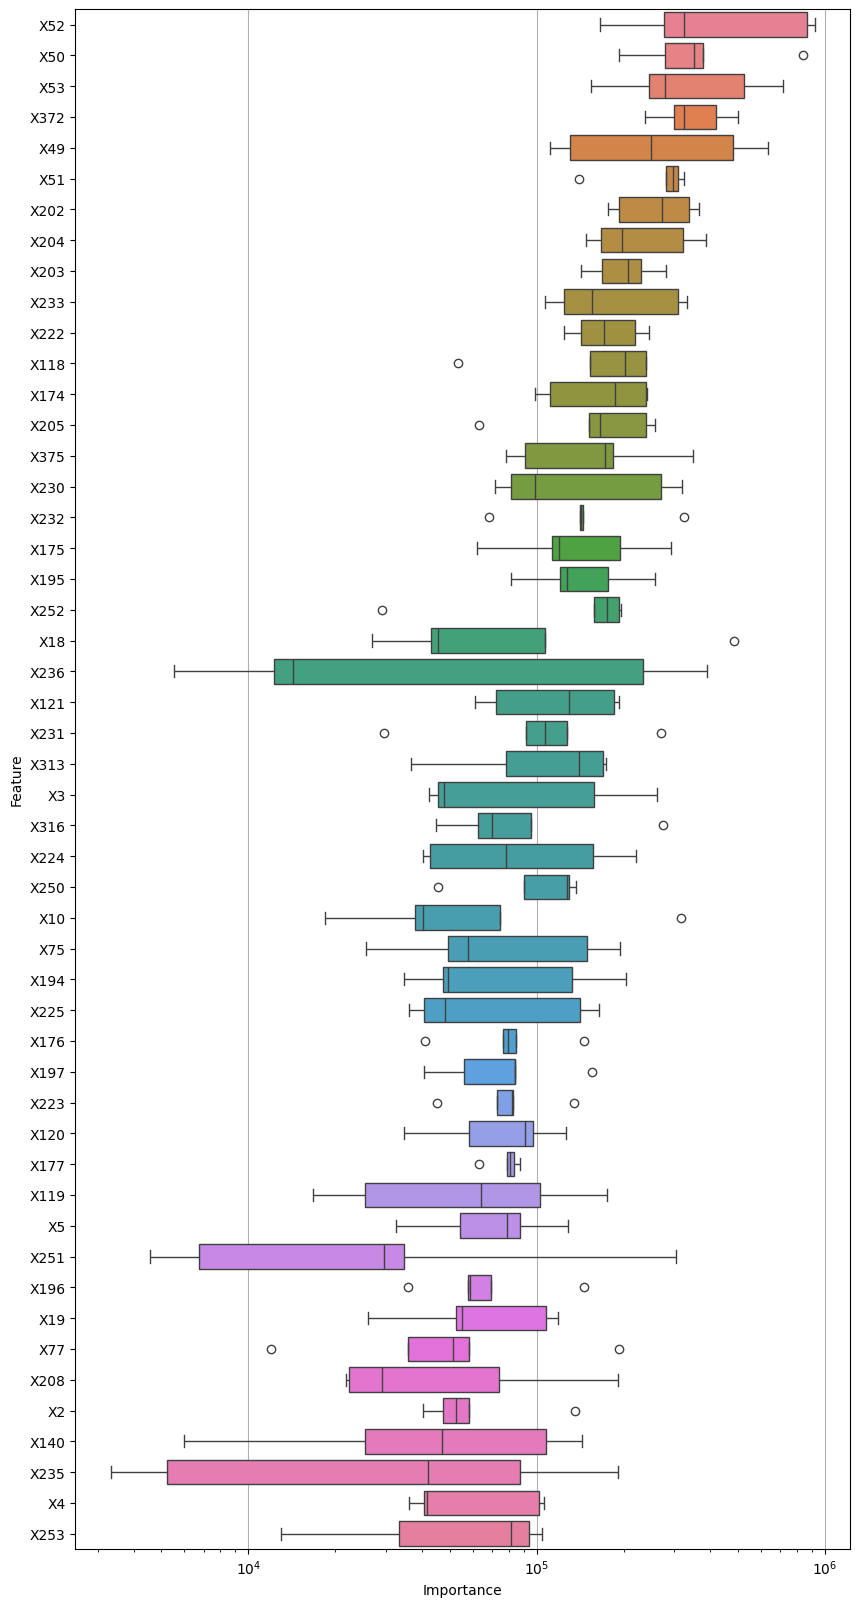

In [92]:
best_iteration = len(ret['valid RMSPE-stdv'])
for i in range(len(folds)):
    y_pred = ret['cvbooster'].boosters[i].predict(X.iloc[folds[i][1]], num_iteration=best_iteration)
    y_true = y.iloc[folds[i][1]]
    print(f"# fold{i} MSE: {mse(y_true, y_pred)}")

    if i == len(folds) - 1:
        np.save('pred_gbdt.npy', y_pred)

plot_importance(ret['cvbooster'], figsize=(10, 20))

In [93]:
lgb_selected = convert_col_2_pos(selected_col)

### Lasso

In [151]:
import numpy as np
from sklearn.linear_model import LassoCV, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer


# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Lasso for Feature Selection and Tuning Hyperparameter
lasso = LassoCV(cv=5, max_iter=10000)  # Using cross-validation
lasso.fit(X_train_scaled, y_train)

# Identify and Retrain on Selected Features
coefficients = lasso.coef_
lasso_selected = np.argsort(np.abs(coefficients))[-10:][::-1]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48529.23748856783, tolerance: 4424.00028558016
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96678.23687508702, tolerance: 4424.00028558016
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116877.75483781844, tolerance: 4424.00028558016
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarni

In [152]:
lasso_selected = np.argsort(np.abs(coefficients))[-10:][::-1]

## Filter Method

We use mutual_info, r value, f value for filter method. Features with higher value in those 3 metric will be selected. Although sklearn didn't provide cv for feature selection using filter method, I defined one. Since filter method is sensitive to nan value. So in each fold, I applied imputer with mean of a column to impute X_train and X_val without having leaking information across folds.  

In [96]:
COLUMNS = X.columns

In [97]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, r_regression, f_regression

def select_feature_fit_transform(X_train, y_train, X_test,
                                 feature_selection_method_label='mutual_info_regression',
                                 num_feature=10, show_plot=False):

    X_train_selected, selector = select_feature_fit(X_train, y_train, feature_selection_method_label, num_feature, show_plot=show_plot)

    X_test_selected = selector.transform(X_test)

    return X_train_selected, X_test_selected, selector

def select_feature_fit(X, y,
                       feature_selection_method_label='mutual_info_regression',
                       num_feature=10,
                       show_plot=False,
                       feature_names=COLUMNS):
    if feature_selection_method_label == 'mutual_info_regression':
        feature_selection_method = mutual_info_regression
    elif feature_selection_method_label == 'r_regression':
        feature_selection_method = r_regression
    elif feature_selection_method_label == 'f_regression':
        feature_selection_method = f_regression

    selector = SelectKBest(feature_selection_method, k=num_feature)
    X_selected = selector.fit_transform(X, y)

    if show_plot:
        scores = selector.scores_
        num_feature_names = [int(str[1:]) for str in feature_names]
        feat_score = pd.Series(scores, num_feature_names).sort_index()

        feat_score.plot(kind='bar', color='teal')
        plt.xticks(ticks=range(0, len(feat_score), 50)) # Adjust the freq
        plt.show()

        selected_index = feat_score.rank(ascending=False).sort_values()[:num_feature].index
        feat_score[selected_index].plot(kind='barh',color='teal')
        plt.show()
    return X_selected, selector


In [98]:
from sklearn.impute import SimpleImputer
def feature_filter_cv(X_train, y_train, X_test, y_test,
                      feature_selection_method_label='mutual_info_regression',
                      n_folds=5, num_feature=10, using_perf_weighted=False,
                      model_type=None, show_plot=True):

    # Time series cross-validation setup
    tscv = overlapping_time_series_split(X_train, n_folds)

    # Arrays to store validation performances and model paths
    validation_performances = []
    model_paths = []

    selected_features = np.zeros((X_train.shape[1],))

    num_epochs = 500
    patience = 10
    batch_size = 128

    # Training the model using time series cross-validation
    for fold, (train_index, val_index) in enumerate(tscv):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Handling NaN values
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_fold)
        X_test_imputed = imputer.transform(X_val_fold)

        X_train_imputed, X_test_imputed, selector = select_feature_fit_transform(
                                                                X_train_imputed,
                                                                y_train_fold,
                                                                X_test_imputed,
                                                                feature_selection_method_label,
                                                                num_feature,
                                                                show_plot)

        selected_features += selector.get_support().astype(int)


    final_features = np.argsort(selected_features)[-10:]

    return final_features

One can choose to set show_plot=True to see the value of top important features and the overview of all features in one fold.

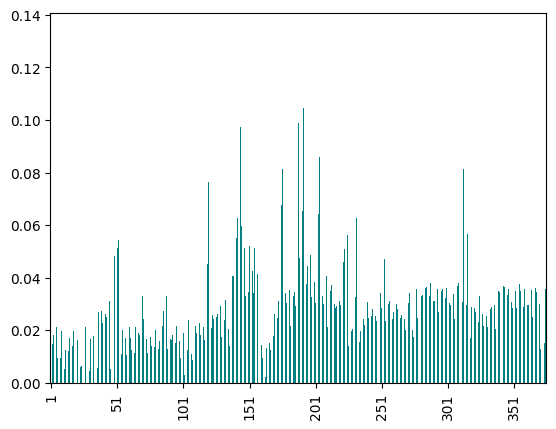

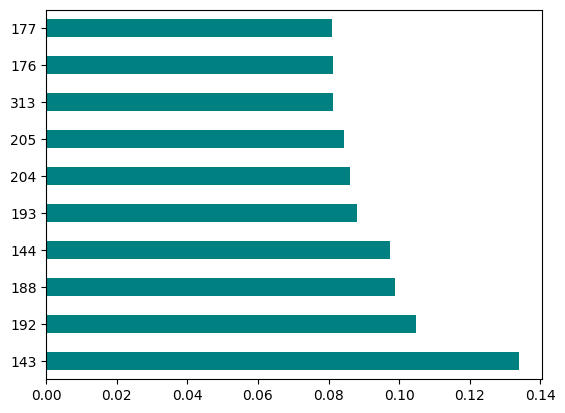

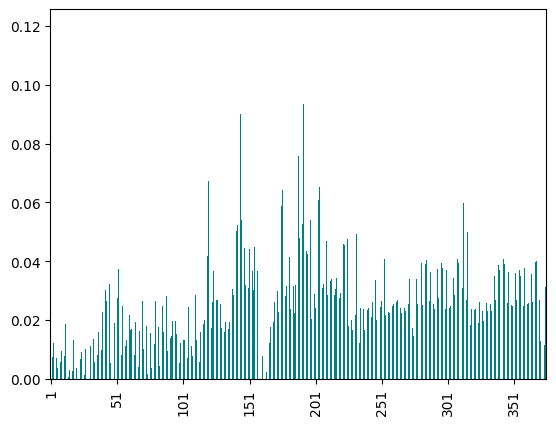

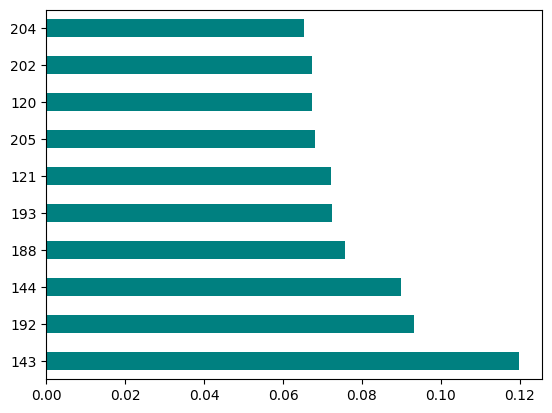

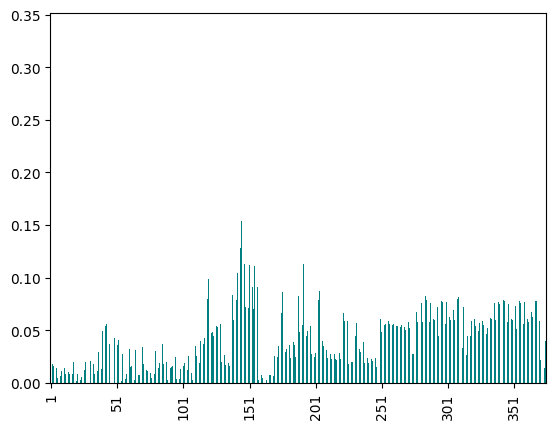

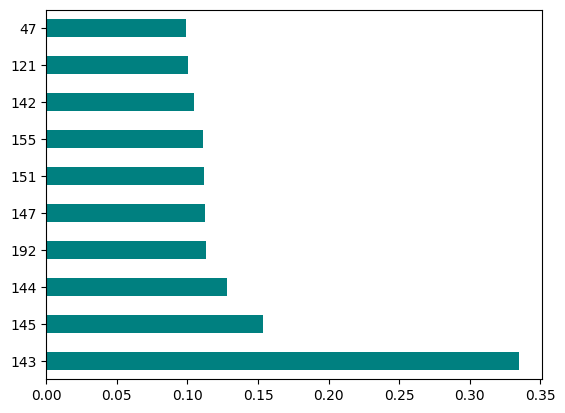

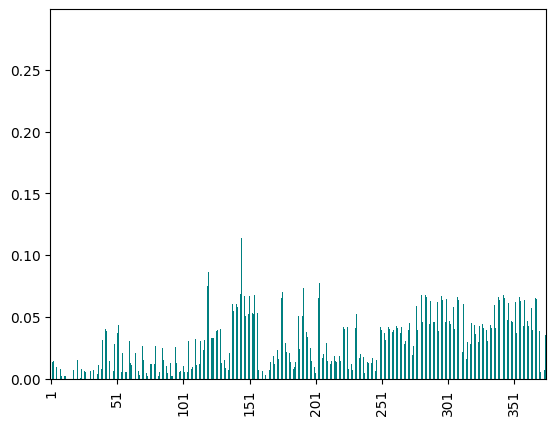

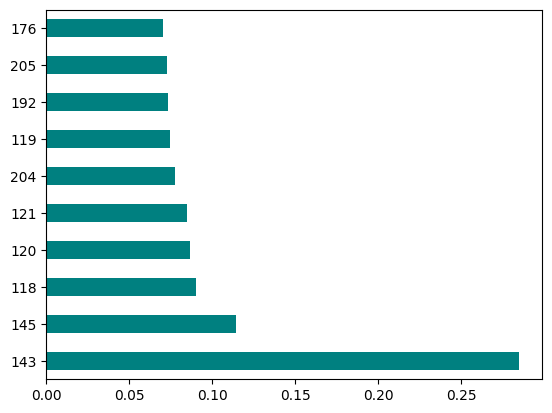

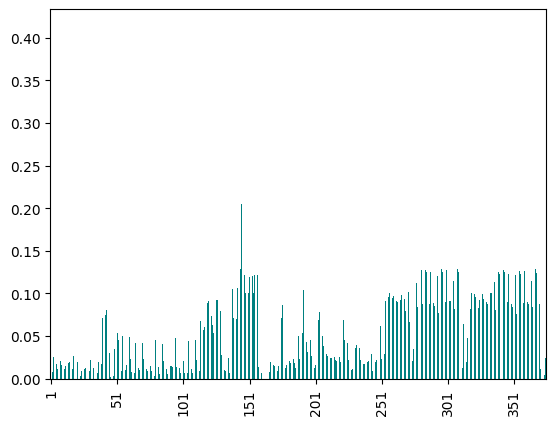

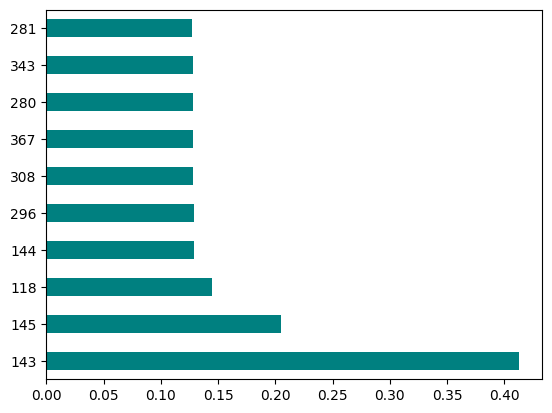

In [99]:
mutual_info_selected = feature_filter_cv(X_train, y_train, X_test, y_test, 'mutual_info_regression')
r_selected = feature_filter_cv(X_train, y_train, X_test, y_test, 'r_regression', show_plot=False)
f_selected = feature_filter_cv(X_train, y_train, X_test, y_test, 'f_regression', show_plot=False)

## Wrapper Method

One can also try to use wrapper method, which is a much exclusive way to search for better combonation of features given the model you want(here we choose LGBMRegressor) and the number of features you want.

Since this is an exclusive way, it require huge computation power. I just listed it here as work finished but didnt apply in the final model.

In [ ]:
# Feature Selection
selector = RFE(LGBMRegressor(), n_features_to_select=10, step=1)
X_selected = selector.fit_transform(X_train, y_train)

selected_features = X.columns[selector.support_]
print("Selected features:", selected_features)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.602850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 95526
[LightGBM] [Info] Number of data points in the train set: 1317957, number of used features: 375
[LightGBM] [Info] Start training from score -0.040727
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.251343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 95271
[LightGBM] [Info] Number of data points in the train set: 1317957, number of used features: 374
[LightGBM] [Info] Start training from score -0.040727
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.779522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 95016
[LightGBM] [Info] Number of data points in the train set: 1317957, number of used features: 373
[LightGBM] [I

In [ ]:
RFE_lgb_selected = convert_col_2_pos(['X203', 'X230', 'X232', 'X233', 'X313', 'X372', 'X49', 'X50', 'X51',
       'X52'])

## Package of feature selection

In [54]:
def feature_select(feature_selection_method):
    if feature_selection_method == 'lgb':
        final_features = lgb_selected
    elif feature_selection_method == 'lasso':
        final_features = lasso_selected
    elif feature_selection_method == 'mutual_info_regression':
        final_features = mutual_info_selected
    elif feature_selection_method == 'r_regression':
        final_features = r_selected
    elif feature_selection_method == 'f_regression':
        final_features = f_selected
    return final_features

# Model

## TABNET

In [40]:
if not os.path.exists(os.path.join(DATA_DIR, 'model', 'tabnet')):
    os.makedirs(os.path.join(DATA_DIR, 'model', 'tabnet'))

In [68]:
from pytorch_tabnet.tab_model import TabNetRegressor
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.impute import SimpleImputer
import numpy as np
import torch

# # Reshape y for compatibility with TabNet
# X = X.to_numpy()
# y = y.to_numpy().reshape(-1, 1)

def tabnet_pred(feature_selection_method, scheduler_type=None):
    device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device_type)

    final_features = feature_select(feature_selection_method)
    model_type = 'tabnet'

    for i in [3, 5, 7, 9]:
        X_train_final = X_train[:, final_features[:i]]
        X_test_final = X_test[:, final_features[:i]]

        imputer = SimpleImputer(strategy='mean')
        X_train_final = imputer.fit_transform(X_train_final)
        X_test_final = imputer.transform(X_test_final)

        if scheduler_type == 'cosine':
            scheduler_params = dict(T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=True)
            scheduler_fn = CosineAnnealingWarmRestarts
        else:
            scheduler_params = {'mode': 'min', 'min_lr': 1e-4, 'patience': 10, 'factor': 0.5, 'verbose': True}
            scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau

        tabnet_model = TabNetRegressor(
            optimizer_fn=torch.optim.Adam,
            optimizer_params={'lr': 1e-4},
            scheduler_fn=scheduler_fn,
            scheduler_params=scheduler_params,
            device_name=device_type
        )

        # Train the model
        tabnet_model.fit(
            X_train_final, y_train.reshape(-1, 1),
            eval_set=[(X_test_final, y_test.reshape(-1, 1))],
            max_epochs=100, # Adjust as needed
            patience=5,
            batch_size=512*20,
            virtual_batch_size=512,
            eval_metric=[RMSPE],
            loss_fn=RMSPELoss_torch
        )

        final_prediction = tabnet_model.predict(X_test_final)


        # train the model
        model_save_dir = os.path.join(DATA_DIR, 'model', model_type.upper())
        model_file_name = f'{DATA_LABEL}_{model_type}_{feature_selection_method}_{i}.pt'
        model_path = os.path.join(model_save_dir, model_file_name)
        tabnet_model.save_model(model_path)

        plot_save_dir = os.path.join(DATA_DIR, 'plot', model_type.upper())
        os.makedirs(plot_save_dir, exist_ok=True)
        plot_file_name = f'{DATA_LABEL}_{model_type}_{feature_selection_method}_{i}.png'
        plt.plot(y_test)
        plt.plot(final_prediction)
        plt.title(plot_file_name)
        plt.savefig(os.path.join(plot_save_dir, plot_file_name))
        plt.close()

        pred_save_dir = os.path.join(DATA_DIR, 'pred', model_type.upper())
        os.makedirs(pred_save_dir, exist_ok=True)
        pred_file_name = f'{DATA_LABEL}_{model_type}_{feature_selection_method}_{i}.txt'
        np.savetxt(os.path.join(pred_save_dir, pred_file_name), final_prediction, delimiter=',')




## MLP

### MLP torch

In [42]:
model_save_dir = os.path.join(DATA_DIR, 'model', 'MLP')
os.makedirs(model_save_dir, exist_ok=True)

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

class MLP(nn.Module):
    def __init__(self, input_features=NUM_FEATURE, hidden=[50,100,50], dropout_rate=0.5, bn=True):
        super(MLP, self).__init__()

        layers = []
        if bn:
            for i in range(len(hidden)):
                if len(layers) == 0:
                    layers.extend([nn.Linear(input_features, hidden[i]),
                                   nn.BatchNorm1d(hidden[i]),
                                   nn.ReLU(),
                                #    nn.Dropout(dropout_rate)
                                   ])
                else:
                    layers.extend([nn.Linear(hidden[i-1], hidden[i]),
                                   nn.BatchNorm1d(hidden[i]),
                                   nn.ReLU(),
                                   ])
        else:
            for i in range(len(hidden)):
                if len(layers) == 0:
                    layers.extend([nn.Linear(input_features, hidden[i]),
                                #    nn.BatchNorm1d(hidden[i]),
                                   nn.ReLU(),
                                #    nn.Dropout(dropout_rate)
                                   ])
                else:
                    layers.extend([nn.Linear(hidden[i-1], hidden[i]),
                                   nn.BatchNorm1d(hidden[i]),
                                   nn.ReLU(),
                                   ])

        layers.append(nn.Linear(hidden[-1], 1))

        # layers = [
        #     nn.Linear(input_features, hidden),
        #     nn.BatchNorm1d(hidden),
        #     nn.ReLU(),
        #     nn.Dropout(dropout_rate),
        #     nn.Linear(hidden, hidden),
        #     nn.BatchNorm1d(hidden),
        #     nn.ReLU(),
        #     nn.Linear(hidden, hidden),
        #     nn.BatchNorm1d(hidden),
        #     nn.ReLU(),
        #     nn.Linear(hidden, 1)
        # ]
        # layers = [
        #     nn.Linear(input_features, hidden),
        #     nn.ReLU(),
        #     nn.Dropout(dropout_rate),
        #     nn.Linear(hidden, hidden),
        #     nn.ReLU(),
        #     nn.Linear(hidden, hidden),
        #     nn.ReLU(),
        #     nn.Linear(hidden, 1)
        # ]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
class AdaptiveLR:
    def __init__(self, optimizer, init_lr, tol=1e-4, factor=5.0):
        self.optimizer = optimizer
        self.init_lr = init_lr
        self.tol = tol
        self.factor = factor
        self.best_loss = float('inf')
        self.epoch_since_improvement = 0
        self.last_lr = [init_lr for _ in optimizer.param_groups]

    def step(self, current_loss):
        if self.best_loss - current_loss > self.tol:
            self.best_loss = current_loss
            self.epoch_since_improvement = 0
        else:
            self.epoch_since_improvement += 1

            if self.epoch_since_improvement >= 2:
                for param_group in self.optimizer.param_groups:
                    new_lr = max(param_group['lr'] / self.factor, 1e-6)
                    param_group['lr'] = new_lr
                    self.last_lr = [new_lr for _ in self.optimizer.param_groups]
                self.epoch_since_improvement = 0

    def get_lr(self):
        return [param_group['lr'] for param_group in self.optimizer.param_groups]

    def get_last_lr(self):
        return self.last_lr

def train_mlp_tensor(train_loader,
                     val_loader,
                     bn=False, # BatchNorm
                     lr=1e-3, # learning rate
                     num_epochs=500,
                     verbose=True,
                     verbose_period=10,
                     model_save_dir=os.path.join(DATA_DIR, 'model', 'MLP'),
                     save_model=True,
                     model_file_name=None,
                     early_stop=True,
                     patience=10,
                     num_feature=10,
                     ):

    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Define the model
    model = MLP(bn=bn, input_features=num_feature).to(device)

    # Define the optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = AdaptiveLR(optimizer, init_lr=lr)

    # Training loop
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()

        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            output = output.squeeze()
            loss = rmspe_torch(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)

        # Step the scheduler at the end of each epoch
        scheduler.step(epoch_loss)

        # Optionally, print the current learning rate
        current_lr = scheduler.get_last_lr()[0]

        # Evaluate the model
        model.eval()

        val_loss = 0
        val_preds = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                val_pred = model(X_batch)
                val_pred = val_pred.squeeze()
                val_preds.append(val_pred)
                val_loss += rmspe_torch(y_batch, val_pred).item()
            val_loss /= len(val_loader)
            val_pred = torch.cat(val_preds, dim=0)

        if verbose and not epoch % verbose_period:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss}, Val Loss: {val_loss}")

        # Check for improvement and save the model
        if val_loss < best_loss:
            best_loss = val_loss
            best_pred = val_pred
            early_stop_counter = 0
            if save_model and model_file_name:
                os.makedirs(model_save_dir, exist_ok=True)
                # model_file_name = f'mlp_model_fold_{fold}.pth'
                model_path = os.path.join(model_save_dir, model_file_name)
                torch.save(model, model_path)  # Saving model state dictionary
                print(f"Model improved and saved to {model_path}")
        else:
            early_stop_counter += 1

        if early_stop and early_stop_counter >= patience:
            early_stop_counter = 0
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return model, best_loss, best_pred


In [45]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32)
        else:
            self.X = X
            self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [46]:
def preprocess_torch(X_train, y_train, X_test, y_test,
                     feature_selection_method_label='mutual_info_regression',
                     batch_size=128, select_feature=True, standardize_data=True,
                     num_feature=10, show_plot=False,
                     ):
    # from dataframe to dataloader

    # Handling NaN values
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # feature seleciton
    selector = None
    if select_feature:
        X_train_imputed, X_test_imputed, selector = select_feature_fit_transform(
                                                        X_train_imputed,
                                                        y_train,
                                                        X_test_imputed,
                                                        feature_selection_method_label,
                                                        num_feature,
                                                        show_plot)
    # Standardization
    scaler = None
    if standardize_data:
        scaler = StandardScaler()
        X_train_imputed = scaler.fit_transform(X_train_imputed)
        X_test_imputed = scaler.transform(X_test_imputed)


    # connvet to tensor
    X_train_imputed_tensor = torch.tensor(X_train_imputed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

    X_test_imputed_tensor = torch.tensor(X_test_imputed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # use dataloader
    train_dataset = TimeSeriesDataset(X_train_imputed_tensor, y_train_tensor)
    test_dataset = TimeSeriesDataset(X_test_imputed_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, selector, scaler



In [100]:
import numpy as np
import os
import torch
from sklearn.preprocessing import MinMaxScaler

def mlp_pred(feature_selection_method):
    final_features = feature_select(feature_selection_method)
    model_type = 'mlp'

    for i in [3, 5, 7, 9]:
        X_train_final = X_train[:, final_features[:i]]
        X_test_final = X_test[:, final_features[:i]]

        imputer = SimpleImputer(strategy='mean')
        X_train_final = imputer.fit_transform(X_train_final)
        X_test_final = imputer.transform(X_test_final)



        train_loader_fold, test_loader_fold, _, _ = preprocess_torch(
                                                    X_train_final, y_train,
                                                    X_test_final, y_test,
                                                    select_feature=False,
                                                    show_plot=False)

        # train the model
        model_file_name = f'{DATA_LABEL}_{model_type}_{feature_selection_method}_{i}.pth'
        model, best_loss, final_prediction = train_mlp_tensor(train_loader_fold, test_loader_fold,
                                                            model_file_name=model_file_name,
                                                            num_feature=i,
                                                            num_epochs=500,
                                                            save_model=True,
                                                            early_stop=True)

        plot_save_dir = os.path.join(DATA_DIR, 'plot', model_type.upper())
        os.makedirs(plot_save_dir, exist_ok=True)
        plot_file_name = f'{DATA_LABEL}_{model_type}_{feature_selection_method}_{i}.png'
        plt.plot(y_test)

        if torch.cuda.is_available():
            final_prediction = final_prediction.cpu()

        plt.plot(final_prediction.numpy())
        plt.title(plot_file_name)
        plt.savefig(os.path.join(plot_save_dir, plot_file_name))
        plt.close()

        pred_save_dir = os.path.join(DATA_DIR, 'pred', model_type.upper())
        os.makedirs(pred_save_dir, exist_ok=True)
        pred_file_name = f'{DATA_LABEL}_{model_type}_{feature_selection_method}_{i}.txt'
        np.savetxt(os.path.join(pred_save_dir, pred_file_name), final_prediction.numpy(), delimiter=',')



### MLP from sklearn

To show work, here I analyze the difference between self-defined torch MLP and the one from sklearn. I also list a refined method of feature selecting here.

Since we are not sure whether selected features each fold is suitable for the training for a sepecific model. For instance, for the lgb_selected, LGBMRegressor might have better performance than other models since it is trained from LGBMRegressor.

So in each fold, after picking features, I will train it with selected features and evaluate with the validation set. And I will divide the importance of selected feature with the perfomance. In such a way, we can punish feature leading to bad predictioin and boost feature lead to good.

In [ ]:
import numpy as np
import os
import joblib
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
# # Reshape y for compatibility with TabNet
# X = X.to_numpy()
# y = y.to_numpy().reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy().ravel(), test_size=0.1, shuffle=False)
feature_selection_method_label = 'r_regression'
using_perf_weighted = True

# Time series cross-validation setup
tscv = overlapping_time_series_split(X_train)

model_save_dir = os.path.join(DATA_DIR, 'model', 'MLP')
os.makedirs(model_save_dir, exist_ok=True)

# Arrays to store validation performances and model paths
validation_performances = []
model_paths = []

selected_features = np.zeros((X_train.shape[1],))

# Training the model using time series cross-validation
for fold, (train_index, val_index) in enumerate(tscv):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Handling NaN values
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train_fold_imputed = imputer.fit_transform(X_train_fold)
    X_val_fold_imputed = imputer.transform(X_val_fold)

    # feature seleciton
    X_train_fold_selected, X_val_fold_selected, selector = select_feature_fit_transform(
                                                           X_train_fold_imputed,
                                                           y_train_fold,
                                                           X_val_fold_imputed,
                                                           feature_selection_method_label
                                                           )

    # Initialize and train the MLP model
    mlp_model = MLPRegressor(hidden_layer_sizes=(50,100,50),
                             max_iter=500,
                             solver='adam',
                             learning_rate='adaptive',
                             learning_rate_init=1e-3,
                             verbose=True)

    mlp_model.fit(X_train_fold_selected, y_train_fold)

    # Evaluate the model
    val_pred = mlp_model.predict(X_val_fold_selected)
    val_performance = mean_squared_error(y_val_fold, val_pred)
    validation_performances.append(val_performance)
    if using_perf_weighted:
        selected_features += selector.get_support().astype(int) / val_performance
    else:
        selected_features += selector.get_support().astype(int)

# Initialize and train the MLP model
final_features = np.argsort(selected_features)[-10:]
X_train_final = X_train[:,final_features]
X_test_final = X_test[:, final_features]
X_train_final_imputed = imputer.fit_transform(X_train_final)
X_test_final_imputed = imputer.transform(X_test_final)

mlp_model = MLPRegressor(hidden_layer_sizes=(50,100,50),
                            max_iter=500,
                            solver='adam',
                            learning_rate='adaptive',
                            learning_rate_init=1e-3,
                            verbose=True)
mlp_model.fit(X_train_final_imputed, y_train)

model_file_name = f'mlp_{feature_selection_method_label}.joblib'
model_path = os.path.join(model_save_dir, model_file_name)
joblib.dump(mlp_model, model_path)

final_prediction = mlp_model.predict(X_test_final_imputed)



Iteration 1, loss = 107.91754553
Iteration 2, loss = 107.67123956
Iteration 3, loss = 107.61946434
Iteration 4, loss = 107.58307020
Iteration 5, loss = 107.53319534
Iteration 6, loss = 107.51009932
Iteration 7, loss = 107.48458470
Iteration 8, loss = 107.40105711
Iteration 9, loss = 107.39135235
Iteration 10, loss = 107.33078223
Iteration 11, loss = 107.29626551
Iteration 12, loss = 107.24383084
Iteration 13, loss = 107.21201985
Iteration 14, loss = 107.25300386
Iteration 15, loss = 107.09918279
Iteration 16, loss = 107.05100267
Iteration 17, loss = 107.03804037
Iteration 18, loss = 106.99244305
Iteration 19, loss = 106.85676494
Iteration 20, loss = 106.91170032
Iteration 21, loss = 106.77994427
Iteration 22, loss = 106.72356377
Iteration 23, loss = 106.61719705
Iteration 24, loss = 106.64218683
Iteration 25, loss = 106.57996620
Iteration 26, loss = 106.52315484
Iteration 27, loss = 106.38585602
Iteration 28, loss = 106.42542481
Iteration 29, loss = 106.26197120
Iteration 30, loss = 10

/Users/linyukai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Iteration 1, loss = 119.11111427
Iteration 2, loss = 118.22342934
Iteration 3, loss = 117.96614001
Iteration 4, loss = 117.74758028
Iteration 5, loss = 117.55797374
Iteration 6, loss = 117.31034964
Iteration 7, loss = 117.05704828
Iteration 8, loss = 116.79571095
Iteration 9, loss = 116.57884135
Iteration 10, loss = 116.32076537
Iteration 11, loss = 115.95613107
Iteration 12, loss = 115.72581607
Iteration 13, loss = 115.58106005
Iteration 14, loss = 115.40434214
Iteration 15, loss = 115.18692276
Iteration 16, loss = 114.83591782
Iteration 17, loss = 114.63280718
Iteration 18, loss = 114.36985855
Iteration 19, loss = 114.23499095
Iteration 20, loss = 114.08211898
Iteration 21, loss = 113.68784286
Iteration 22, loss = 113.56436619
Iteration 23, loss = 113.46594659
Iteration 24, loss = 113.18515114
Iteration 25, loss = 112.94572636
Iteration 26, loss = 112.89157122
Iteration 27, loss = 112.47183618
Iteration 28, loss = 112.58255085
Iteration 29, loss = 112.09269571
Iteration 30, loss = 11

/Users/linyukai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Iteration 1, loss = 96.09430121
Iteration 2, loss = 95.05893024
Iteration 3, loss = 93.87753771
Iteration 4, loss = 92.77754964
Iteration 5, loss = 91.88136511
Iteration 6, loss = 91.23385706
Iteration 7, loss = 90.18750626
Iteration 8, loss = 89.59520769
Iteration 9, loss = 89.26454591
Iteration 10, loss = 88.56667855
Iteration 11, loss = 87.97067465
Iteration 12, loss = 87.33593477
Iteration 13, loss = 86.93784934
Iteration 14, loss = 86.18493466
Iteration 15, loss = 86.05712378
Iteration 16, loss = 85.45409650
Iteration 17, loss = 84.98419891
Iteration 18, loss = 84.30612295
Iteration 19, loss = 84.13113124
Iteration 20, loss = 83.50393872
Iteration 21, loss = 82.76152144
Iteration 22, loss = 82.87714393
Iteration 23, loss = 82.09223777
Iteration 24, loss = 81.60089354
Iteration 25, loss = 81.16059154
Iteration 26, loss = 80.60657393
Iteration 27, loss = 80.47037900
Iteration 28, loss = 79.69706580
Iteration 29, loss = 79.38613883
Iteration 30, loss = 79.08914183
Iteration 31, loss 

/Users/linyukai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 104.99823258
Iteration 2, loss = 104.93833165
Iteration 3, loss = 104.93098336
Iteration 4, loss = 104.91325466
Iteration 5, loss = 104.90141557
Iteration 6, loss = 104.90107716
Iteration 7, loss = 104.87967403
Iteration 8, loss = 104.87078510
Iteration 9, loss = 104.86485725
Iteration 10, loss = 104.84043502
Iteration 11, loss = 104.83964384
Iteration 12, loss = 104.81077010
Iteration 13, loss = 104.80948377
Iteration 14, loss = 104.78696681
Iteration 15, loss = 104.76583689
Iteration 16, loss = 104.75394590
Iteration 17, loss = 104.75269993
Iteration 18, loss = 104.73333132
Iteration 19, loss = 104.71739752
Iteration 20, loss = 104.67414477
Iteration 21, loss = 104.66925310
Iteration 22, loss = 104.65357512
Iteration 23, loss = 104.63631979
Iteration 24, loss = 104.60295417
Iteration 25, loss = 104.58979087
Iteration 26, loss = 104.57349302
Iteration 27, loss = 104.54163824
Iteration 28, loss = 104.50276811
Iteration 29, loss = 104.48805667
Iteration 30, loss = 10

/Users/linyukai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


## Random Forest

In [74]:
import numpy as np
import os
import joblib
from sklearn.feature_selection import SelectKBest, mutual_info_regression, r_regression, f_regression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

def rf_pred(feature_selection_method):
    final_features = feature_select(feature_selection_method)
    model_type = 'rf'
    for i in [3, 5, 7, 9]:
        X_train_final = X_train[:, final_features[:i]]
        X_test_final = X_test[:, final_features[:i]]

        imputer = SimpleImputer(strategy='mean')
        X_train_final = imputer.fit_transform(X_train_final)
        X_test_final = imputer.transform(X_test_final)

        model = RandomForestRegressor(n_estimators=20)
        model.fit(X_train_final, y_train)
        final_prediction = model.predict(X_test_final)

        # train the model
        model_save_dir = os.path.join(DATA_DIR, 'model', model_type.upper())
        os.makedirs(model_save_dir, exist_ok=True)
        model_file_name = f'{DATA_LABEL}_{model_type}_{feature_selection_method}_{i}.joblib'
        model_path = os.path.join(model_save_dir, model_file_name)
        joblib.dump(model, model_path)

        plot_save_dir = os.path.join(DATA_DIR, 'plot', model_type.upper())
        os.makedirs(plot_save_dir, exist_ok=True)
        plot_file_name = f'{DATA_LABEL}_{model_type}_{feature_selection_method}_{i}.png'
        plt.plot(y_test)
        plt.plot(final_prediction)
        plt.title(plot_file_name)
        plt.savefig(os.path.join(plot_save_dir, plot_file_name))
        plt.close()

        pred_save_dir = os.path.join(DATA_DIR, 'pred', model_type.upper())
        os.makedirs(pred_save_dir, exist_ok=True)
        pred_file_name = f'{DATA_LABEL}_{model_type}_{feature_selection_method}_{i}.txt'
        np.savetxt(os.path.join(pred_save_dir, pred_file_name), final_prediction, delimiter=',')





## Linear

In [71]:
def linear_pred(feature_selection_method):
    final_features = feature_select(feature_selection_method)
    model_type = 'linear'
    for i in [3, 5, 7, 9]:
        X_train_final = X_train[:, final_features[:i]]
        X_test_final = X_test[:, final_features[:i]]

        imputer = SimpleImputer(strategy='mean')
        X_train_final = imputer.fit_transform(X_train_final)
        X_test_final = imputer.transform(X_test_final)

        model = LinearRegression()
        model.fit(X_train_final, y_train)
        final_prediction = model.predict(X_test_final)

        # train the model
        model_save_dir = os.path.join(DATA_DIR, 'model', model_type.upper())
        os.makedirs(model_save_dir, exist_ok=True)
        model_file_name = f'{DATA_LABEL}_{model_type}_{feature_selection_method}_{i}.joblib'
        model_path = os.path.join(model_save_dir, model_file_name)
        joblib.dump(model, model_path)

        plot_save_dir = os.path.join(DATA_DIR, 'plot', model_type.upper())
        os.makedirs(plot_save_dir, exist_ok=True)
        plot_file_name = f'{DATA_LABEL}_{model_type}_{feature_selection_method}_{i}.png'
        plt.plot(y_test)
        plt.plot(final_prediction)
        plt.title(plot_file_name)
        plt.savefig(os.path.join(plot_save_dir, plot_file_name))
        plt.close()

        pred_save_dir = os.path.join(DATA_DIR, 'pred', model_type.upper())
        os.makedirs(pred_save_dir, exist_ok=True)
        pred_file_name = f'{DATA_LABEL}_{model_type}_{feature_selection_method}_{i}.txt'
        np.savetxt(os.path.join(pred_save_dir, pred_file_name), final_prediction, delimiter=',')

## Training

In [101]:
with timer(f'mlp_{DATA_LABEL}'):
    for method in ['lgb','lasso','mutual_info_regression','r_regression','f_regression']:
        mlp_pred(method)
with timer(f'tabnet_{DATA_LABEL}'):
    for method in ['lgb','lasso','mutual_info_regression','r_regression','f_regression']:
        tabnet_pred(method)
with timer(f'linear_{DATA_LABEL}'):
    for method in ['lgb','lasso','mutual_info_regression','r_regression','f_regression']:
        linear_pred(method)
with timer(f'rf_{DATA_LABEL}'):
    for method in ['lgb','lasso','mutual_info_regression','r_regression','f_regression']:
        rf_pred(method)


Epoch 1/500, Train Loss: 4.511739730834961, Val Loss: 1777.4034483492005
Model improved and saved to /content/drive/MyDrive/clear_street_project/model/MLP/14_16_Y1_mlp_lgb_3.pth
Epoch 11/500, Train Loss: 5.851468086242676, Val Loss: 4242.9719577979595
Early stopping triggered at epoch 11
Epoch 1/500, Train Loss: 15.383605003356934, Val Loss: 2742.487179790224
Model improved and saved to /content/drive/MyDrive/clear_street_project/model/MLP/14_16_Y1_mlp_lgb_5.pth
Epoch 11/500, Train Loss: 570.0537109375, Val Loss: 3269.4634492463947
Early stopping triggered at epoch 11
Epoch 1/500, Train Loss: 47.72274398803711, Val Loss: 2407.2808295466143
Model improved and saved to /content/drive/MyDrive/clear_street_project/model/MLP/14_16_Y1_mlp_lgb_7.pth
Epoch 11/500, Train Loss: 3.0137035846710205, Val Loss: 2685.5319057288375
Early stopping triggered at epoch 11
Epoch 1/500, Train Loss: 6.292830944061279, Val Loss: 1850.1414563722492
Model improved and saved to /content/drive/MyDrive/clear_stree

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1253.35654| val_0_rmspe: 923.2489624023438|  0:00:03s
epoch 1  | loss: 1159.97114| val_0_rmspe: 904.4889526367188|  0:00:06s
epoch 2  | loss: 1072.82329| val_0_rmspe: 874.9017333984375|  0:00:10s
epoch 3  | loss: 990.19666| val_0_rmspe: 838.6232299804688|  0:00:13s
epoch 4  | loss: 905.08544| val_0_rmspe: 803.9556274414062|  0:00:16s
epoch 5  | loss: 820.36903| val_0_rmspe: 758.8411254882812|  0:00:19s
epoch 6  | loss: 747.29976| val_0_rmspe: 715.6181030273438|  0:00:23s
epoch 7  | loss: 697.11936| val_0_rmspe: 679.4946899414062|  0:00:26s
epoch 8  | loss: 635.80758| val_0_rmspe: 634.8724365234375|  0:00:29s
epoch 9  | loss: 579.10381| val_0_rmspe: 595.9568481445312|  0:00:33s
epoch 10 | loss: 525.84832| val_0_rmspe: 551.997802734375|  0:00:36s
epoch 11 | loss: 467.0216| val_0_rmspe: 495.4676818847656|  0:00:39s
epoch 12 | loss: 421.96095| val_0_rmspe: 454.0699157714844|  0:00:43s
epoch 13 | loss: 400.44458| val_0_rmspe: 412.09234619140625|  0:00:46s
epoch 14 | loss: 3

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_lgb_3.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1607.86396| val_0_rmspe: 687.0914916992188|  0:00:03s
epoch 1  | loss: 1566.17147| val_0_rmspe: 679.8346557617188|  0:00:07s
epoch 2  | loss: 1509.819| val_0_rmspe: 647.6610107421875|  0:00:10s
epoch 3  | loss: 1416.16152| val_0_rmspe: 652.7894287109375|  0:00:14s
epoch 4  | loss: 1395.80448| val_0_rmspe: 652.5459594726562|  0:00:17s
epoch 5  | loss: 1291.98242| val_0_rmspe: 656.2755737304688|  0:00:20s
epoch 6  | loss: 1241.09548| val_0_rmspe: 671.22314453125|  0:00:24s
epoch 7  | loss: 1196.96432| val_0_rmspe: 672.4074096679688|  0:00:27s

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmspe = 647.6610107421875


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_lgb_5.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1683.25856| val_0_rmspe: 1374.0899658203125|  0:00:03s
epoch 1  | loss: 1619.9869| val_0_rmspe: 1204.905517578125|  0:00:06s
epoch 2  | loss: 1546.22535| val_0_rmspe: 1032.64892578125|  0:00:10s
epoch 3  | loss: 1507.67653| val_0_rmspe: 1002.9541015625|  0:00:13s
epoch 4  | loss: 1415.97829| val_0_rmspe: 960.3125|  0:00:17s
epoch 5  | loss: 1387.13411| val_0_rmspe: 943.41650390625|  0:00:20s
epoch 6  | loss: 1342.45039| val_0_rmspe: 929.8512573242188|  0:00:24s
epoch 7  | loss: 1280.11301| val_0_rmspe: 914.0585327148438|  0:00:27s
epoch 8  | loss: 1251.40064| val_0_rmspe: 905.8236694335938|  0:00:31s
epoch 9  | loss: 1208.33402| val_0_rmspe: 899.5609741210938|  0:00:34s
epoch 10 | loss: 1190.07873| val_0_rmspe: 893.6412963867188|  0:00:37s
epoch 11 | loss: 1108.38181| val_0_rmspe: 920.3779907226562|  0:00:41s
epoch 12 | loss: 1069.52803| val_0_rmspe: 917.2015380859375|  0:00:44s
epoch 13 | loss: 993.90128| val_0_rmspe: 916.5914916992188|  0:00:47s
epoch 14 | loss: 950.

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_lgb_7.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1165.30115| val_0_rmspe: 2547.068359375|  0:00:03s
epoch 1  | loss: 1121.87485| val_0_rmspe: 1460.0616455078125|  0:00:07s
epoch 2  | loss: 1119.09589| val_0_rmspe: 1169.0928955078125|  0:00:10s
epoch 3  | loss: 1057.25237| val_0_rmspe: 992.2521362304688|  0:00:14s
epoch 4  | loss: 1022.22385| val_0_rmspe: 947.900634765625|  0:00:18s
epoch 5  | loss: 984.61518| val_0_rmspe: 868.92529296875|  0:00:21s
epoch 6  | loss: 950.51888| val_0_rmspe: 852.041259765625|  0:00:25s
epoch 7  | loss: 927.21736| val_0_rmspe: 826.0564575195312|  0:00:28s
epoch 8  | loss: 870.92196| val_0_rmspe: 792.2640991210938|  0:00:31s
epoch 9  | loss: 866.81036| val_0_rmspe: 781.750244140625|  0:00:35s
epoch 10 | loss: 806.05452| val_0_rmspe: 780.8839721679688|  0:00:39s
epoch 11 | loss: 769.57806| val_0_rmspe: 741.11474609375|  0:00:42s
epoch 12 | loss: 857.88687| val_0_rmspe: 723.7925415039062|  0:00:45s
epoch 13 | loss: 755.41056| val_0_rmspe: 701.4676513671875|  0:00:49s
epoch 14 | loss: 750.84

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_lgb_9.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1047.09247| val_0_rmspe: 759.0693359375|  0:00:03s
epoch 1  | loss: 977.84645| val_0_rmspe: 703.4237060546875|  0:00:06s
epoch 2  | loss: 904.42357| val_0_rmspe: 673.3818359375|  0:00:10s
epoch 3  | loss: 860.80688| val_0_rmspe: 623.2632446289062|  0:00:13s
epoch 4  | loss: 798.01245| val_0_rmspe: 582.7252197265625|  0:00:16s
epoch 5  | loss: 749.93794| val_0_rmspe: 547.8458862304688|  0:00:20s
epoch 6  | loss: 694.75796| val_0_rmspe: 510.115234375|  0:00:24s
epoch 7  | loss: 630.90429| val_0_rmspe: 476.9559631347656|  0:00:27s
epoch 8  | loss: 596.04366| val_0_rmspe: 447.1123962402344|  0:00:31s
epoch 9  | loss: 554.7917| val_0_rmspe: 408.0011901855469|  0:00:35s
epoch 10 | loss: 526.95206| val_0_rmspe: 384.22772216796875|  0:00:38s
epoch 11 | loss: 472.28391| val_0_rmspe: 354.1885986328125|  0:00:42s
epoch 12 | loss: 427.4583| val_0_rmspe: 329.1206359863281|  0:00:45s
epoch 13 | loss: 408.33152| val_0_rmspe: 312.9378662109375|  0:00:48s
epoch 14 | loss: 376.18275| va

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_lasso_3.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1356.98245| val_0_rmspe: 434.9974365234375|  0:00:03s
epoch 1  | loss: 1234.66448| val_0_rmspe: 339.0270080566406|  0:00:06s
epoch 2  | loss: 1310.34599| val_0_rmspe: 316.2492980957031|  0:00:10s
epoch 3  | loss: 1164.62877| val_0_rmspe: 321.2548522949219|  0:00:13s
epoch 4  | loss: 1185.00134| val_0_rmspe: 310.8302917480469|  0:00:16s
epoch 5  | loss: 1165.15509| val_0_rmspe: 310.5769348144531|  0:00:19s
epoch 6  | loss: 1091.63005| val_0_rmspe: 329.7614440917969|  0:00:23s
epoch 7  | loss: 1100.28201| val_0_rmspe: 341.4244689941406|  0:00:26s
epoch 8  | loss: 1086.26341| val_0_rmspe: 349.3485107421875|  0:00:29s
epoch 9  | loss: 1000.07238| val_0_rmspe: 319.2026672363281|  0:00:33s
epoch 10 | loss: 985.01424| val_0_rmspe: 305.34124755859375|  0:00:36s
epoch 11 | loss: 1072.82924| val_0_rmspe: 340.528076171875|  0:00:40s
epoch 12 | loss: 877.88254| val_0_rmspe: 323.06097412109375|  0:00:43s
epoch 13 | loss: 1015.55846| val_0_rmspe: 338.9562072753906|  0:00:46s
epoch 1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_lasso_5.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1506.94087| val_0_rmspe: 589.564697265625|  0:00:03s
epoch 1  | loss: 1460.59403| val_0_rmspe: 536.654541015625|  0:00:06s
epoch 2  | loss: 1381.34803| val_0_rmspe: 498.82733154296875|  0:00:10s
epoch 3  | loss: 1415.31835| val_0_rmspe: 501.6821594238281|  0:00:13s
epoch 4  | loss: 1293.6102| val_0_rmspe: 490.4117126464844|  0:00:17s
epoch 5  | loss: 1318.7322| val_0_rmspe: 489.1889343261719|  0:00:20s
epoch 6  | loss: 1291.9548| val_0_rmspe: 495.96282958984375|  0:00:24s
epoch 7  | loss: 1319.83053| val_0_rmspe: 483.78582763671875|  0:00:27s
epoch 8  | loss: 1233.93761| val_0_rmspe: 481.07415771484375|  0:00:31s
epoch 9  | loss: 1105.6441| val_0_rmspe: 485.4658508300781|  0:00:34s
epoch 10 | loss: 1238.29959| val_0_rmspe: 480.7437744140625|  0:00:38s
epoch 11 | loss: 1202.77265| val_0_rmspe: 455.4966125488281|  0:00:41s
epoch 12 | loss: 1075.20592| val_0_rmspe: 471.080810546875|  0:00:45s
epoch 13 | loss: 1025.8285| val_0_rmspe: 438.304931640625|  0:00:48s
epoch 14 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_lasso_7.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1172.84828| val_0_rmspe: 1199.2879638671875|  0:00:03s
epoch 1  | loss: 1187.24696| val_0_rmspe: 971.5933837890625|  0:00:06s
epoch 2  | loss: 1177.15248| val_0_rmspe: 661.7396240234375|  0:00:10s
epoch 3  | loss: 1130.60248| val_0_rmspe: 723.4550170898438|  0:00:13s
epoch 4  | loss: 1041.09066| val_0_rmspe: 541.5220336914062|  0:00:17s
epoch 5  | loss: 1148.15166| val_0_rmspe: 513.7437133789062|  0:00:20s
epoch 6  | loss: 1000.67215| val_0_rmspe: 524.3611450195312|  0:00:23s
epoch 7  | loss: 970.66547| val_0_rmspe: 482.3654479980469|  0:00:27s
epoch 8  | loss: 1022.70445| val_0_rmspe: 466.879150390625|  0:00:30s
epoch 9  | loss: 975.47079| val_0_rmspe: 462.7989196777344|  0:00:34s
epoch 10 | loss: 960.56949| val_0_rmspe: 480.6248474121094|  0:00:37s
epoch 11 | loss: 985.1654| val_0_rmspe: 427.1979064941406|  0:00:40s
epoch 12 | loss: 923.87448| val_0_rmspe: 383.41229248046875|  0:00:44s
epoch 13 | loss: 901.67895| val_0_rmspe: 484.5929870605469|  0:00:47s
epoch 14 | l

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_lasso_9.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 856.71332| val_0_rmspe: 3892.560546875|  0:00:03s
epoch 1  | loss: 858.57023| val_0_rmspe: 2689.969970703125|  0:00:06s
epoch 2  | loss: 834.50379| val_0_rmspe: 2117.910400390625|  0:00:10s
epoch 3  | loss: 819.78666| val_0_rmspe: 1562.83740234375|  0:00:13s
epoch 4  | loss: 822.35103| val_0_rmspe: 1333.5797119140625|  0:00:17s
epoch 5  | loss: 812.21885| val_0_rmspe: 1328.863525390625|  0:00:20s
epoch 6  | loss: 756.00406| val_0_rmspe: 1395.1002197265625|  0:00:24s
epoch 7  | loss: 715.23924| val_0_rmspe: 1470.2220458984375|  0:00:27s
epoch 8  | loss: 708.01814| val_0_rmspe: 1456.658447265625|  0:00:31s
epoch 9  | loss: 689.84085| val_0_rmspe: 1416.6031494140625|  0:00:34s
epoch 10 | loss: 708.23956| val_0_rmspe: 1227.7503662109375|  0:00:37s
epoch 11 | loss: 662.934 | val_0_rmspe: 1184.947265625|  0:00:41s
epoch 12 | loss: 648.07331| val_0_rmspe: 1215.4154052734375|  0:00:44s
epoch 13 | loss: 538.34344| val_0_rmspe: 1126.4656982421875|  0:00:48s
epoch 14 | loss: 580.

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_mutual_info_regression_3.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1265.49469| val_0_rmspe: 6676.25390625|  0:00:03s
epoch 1  | loss: 1159.3484| val_0_rmspe: 4558.8857421875|  0:00:07s
epoch 2  | loss: 1183.03656| val_0_rmspe: 3107.670166015625|  0:00:10s
epoch 3  | loss: 1128.48321| val_0_rmspe: 2413.23876953125|  0:00:14s
epoch 4  | loss: 1124.15495| val_0_rmspe: 1546.89404296875|  0:00:17s
epoch 5  | loss: 981.97382| val_0_rmspe: 1492.232177734375|  0:00:21s
epoch 6  | loss: 1086.72778| val_0_rmspe: 1266.626220703125|  0:00:24s
epoch 7  | loss: 1052.65009| val_0_rmspe: 1161.03173828125|  0:00:28s
epoch 8  | loss: 1020.05878| val_0_rmspe: 997.1244506835938|  0:00:32s
epoch 9  | loss: 1018.63534| val_0_rmspe: 1277.13037109375|  0:00:35s
epoch 10 | loss: 914.311 | val_0_rmspe: 1068.622802734375|  0:00:38s
epoch 11 | loss: 1013.02153| val_0_rmspe: 1113.97607421875|  0:00:42s
epoch 12 | loss: 975.42707| val_0_rmspe: 989.131103515625|  0:00:45s
epoch 13 | loss: 1022.07166| val_0_rmspe: 1022.97802734375|  0:00:48s
epoch 14 | loss: 1025.69

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_mutual_info_regression_5.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1544.4556| val_0_rmspe: 4957.697265625|  0:00:03s
epoch 1  | loss: 1673.84536| val_0_rmspe: 1967.8310546875|  0:00:06s
epoch 2  | loss: 1641.48962| val_0_rmspe: 1752.3260498046875|  0:00:10s
epoch 3  | loss: 1643.89527| val_0_rmspe: 1624.224365234375|  0:00:13s
epoch 4  | loss: 1588.56699| val_0_rmspe: 1597.81787109375|  0:00:17s
epoch 5  | loss: 1548.6381| val_0_rmspe: 1548.3165283203125|  0:00:20s
epoch 6  | loss: 1575.1674| val_0_rmspe: 1466.030517578125|  0:00:23s
epoch 7  | loss: 1344.02251| val_0_rmspe: 1380.247314453125|  0:00:27s
epoch 8  | loss: 1449.97186| val_0_rmspe: 1347.175537109375|  0:00:31s
epoch 9  | loss: 1445.69421| val_0_rmspe: 1282.745849609375|  0:00:34s
epoch 10 | loss: 1443.09502| val_0_rmspe: 1228.1123046875|  0:00:38s
epoch 11 | loss: 1382.50722| val_0_rmspe: 1221.2764892578125|  0:00:41s
epoch 12 | loss: 1271.77461| val_0_rmspe: 1207.2540283203125|  0:00:45s
epoch 13 | loss: 1366.61211| val_0_rmspe: 1112.5565185546875|  0:00:48s
epoch 14 | l

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_mutual_info_regression_7.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1212.75547| val_0_rmspe: 1879.9412841796875|  0:00:03s
epoch 1  | loss: 998.04336| val_0_rmspe: 1481.36572265625|  0:00:06s
epoch 2  | loss: 995.9681| val_0_rmspe: 1301.135498046875|  0:00:10s
epoch 3  | loss: 920.49295| val_0_rmspe: 1061.6710205078125|  0:00:13s
epoch 4  | loss: 980.45682| val_0_rmspe: 985.774658203125|  0:00:17s
epoch 5  | loss: 987.51586| val_0_rmspe: 837.4640502929688|  0:00:20s
epoch 6  | loss: 998.33869| val_0_rmspe: 766.7905883789062|  0:00:24s
epoch 7  | loss: 930.32166| val_0_rmspe: 778.9482421875|  0:00:28s
epoch 8  | loss: 987.33846| val_0_rmspe: 722.6858520507812|  0:00:31s
epoch 9  | loss: 932.70997| val_0_rmspe: 690.3353881835938|  0:00:35s
epoch 10 | loss: 926.59282| val_0_rmspe: 726.1536254882812|  0:00:38s
epoch 11 | loss: 877.93084| val_0_rmspe: 642.5974731445312|  0:00:42s
epoch 12 | loss: 798.58785| val_0_rmspe: 641.6888427734375|  0:00:45s
epoch 13 | loss: 807.45749| val_0_rmspe: 608.4334716796875|  0:00:49s
epoch 14 | loss: 911.43

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_mutual_info_regression_9.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1102.31253| val_0_rmspe: 761.836669921875|  0:00:03s
epoch 1  | loss: 1047.67339| val_0_rmspe: 712.9276733398438|  0:00:07s
epoch 2  | loss: 958.33635| val_0_rmspe: 669.6761474609375|  0:00:10s
epoch 3  | loss: 918.88436| val_0_rmspe: 618.56689453125|  0:00:14s
epoch 4  | loss: 864.27541| val_0_rmspe: 576.738525390625|  0:00:17s
epoch 5  | loss: 817.50522| val_0_rmspe: 538.6473999023438|  0:00:21s
epoch 6  | loss: 761.48245| val_0_rmspe: 492.1207580566406|  0:00:24s
epoch 7  | loss: 688.0049| val_0_rmspe: 454.1639709472656|  0:00:28s
epoch 8  | loss: 636.94228| val_0_rmspe: 411.0306701660156|  0:00:31s
epoch 9  | loss: 605.73763| val_0_rmspe: 389.6812438964844|  0:00:35s
epoch 10 | loss: 533.80276| val_0_rmspe: 356.5695495605469|  0:00:38s
epoch 11 | loss: 506.83453| val_0_rmspe: 329.391357421875|  0:00:41s
epoch 12 | loss: 464.93938| val_0_rmspe: 297.1429443359375|  0:00:45s
epoch 13 | loss: 432.81927| val_0_rmspe: 275.556396484375|  0:00:48s
epoch 14 | loss: 392.5630

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_r_regression_3.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1318.70809| val_0_rmspe: 221.82139587402344|  0:00:03s
epoch 1  | loss: 1276.3961| val_0_rmspe: 225.98629760742188|  0:00:06s
epoch 2  | loss: 1241.60103| val_0_rmspe: 247.34417724609375|  0:00:10s
epoch 3  | loss: 1224.5606| val_0_rmspe: 256.27227783203125|  0:00:13s
epoch 4  | loss: 1124.06023| val_0_rmspe: 268.3895568847656|  0:00:17s
epoch 5  | loss: 1092.71641| val_0_rmspe: 287.24249267578125|  0:00:20s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_0_rmspe = 221.82139587402344


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_r_regression_5.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1482.99289| val_0_rmspe: 442.097412109375|  0:00:03s
epoch 1  | loss: 1447.58759| val_0_rmspe: 435.5618896484375|  0:00:06s
epoch 2  | loss: 1407.26158| val_0_rmspe: 420.10992431640625|  0:00:10s
epoch 3  | loss: 1397.42545| val_0_rmspe: 400.8612060546875|  0:00:14s
epoch 4  | loss: 1255.95623| val_0_rmspe: 403.2286071777344|  0:00:17s
epoch 5  | loss: 1256.00017| val_0_rmspe: 388.09991455078125|  0:00:20s
epoch 6  | loss: 1173.5178| val_0_rmspe: 377.8760681152344|  0:00:24s
epoch 7  | loss: 1206.60925| val_0_rmspe: 388.6331481933594|  0:00:27s
epoch 8  | loss: 1145.48538| val_0_rmspe: 386.39971923828125|  0:00:31s
epoch 9  | loss: 1100.3034| val_0_rmspe: 399.4007568359375|  0:00:34s
epoch 10 | loss: 1036.30391| val_0_rmspe: 412.60089111328125|  0:00:37s
epoch 11 | loss: 1053.33713| val_0_rmspe: 413.54901123046875|  0:00:41s

Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_rmspe = 377.8760681152344


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_r_regression_7.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1213.4171| val_0_rmspe: 749.4595336914062|  0:00:03s
epoch 1  | loss: 1140.00561| val_0_rmspe: 662.947509765625|  0:00:07s
epoch 2  | loss: 1222.57621| val_0_rmspe: 712.93017578125|  0:00:10s
epoch 3  | loss: 1191.04044| val_0_rmspe: 898.8822631835938|  0:00:14s
epoch 4  | loss: 1128.97087| val_0_rmspe: 1062.452880859375|  0:00:17s
epoch 5  | loss: 1143.72253| val_0_rmspe: 929.2711791992188|  0:00:21s
epoch 6  | loss: 1102.52686| val_0_rmspe: 1026.3526611328125|  0:00:24s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_rmspe = 662.947509765625


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_r_regression_9.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1107.6156| val_0_rmspe: 1120.418212890625|  0:00:03s
epoch 1  | loss: 1036.68459| val_0_rmspe: 1013.2907104492188|  0:00:07s
epoch 2  | loss: 952.63126| val_0_rmspe: 962.094482421875|  0:00:10s
epoch 3  | loss: 940.42692| val_0_rmspe: 887.1827392578125|  0:00:14s
epoch 4  | loss: 861.20815| val_0_rmspe: 831.7132568359375|  0:00:17s
epoch 5  | loss: 817.07957| val_0_rmspe: 781.6878662109375|  0:00:20s
epoch 6  | loss: 775.74032| val_0_rmspe: 729.4127807617188|  0:00:24s
epoch 7  | loss: 758.88745| val_0_rmspe: 692.5521850585938|  0:00:27s
epoch 8  | loss: 695.10452| val_0_rmspe: 636.4522705078125|  0:00:31s
epoch 9  | loss: 621.05183| val_0_rmspe: 588.0631713867188|  0:00:34s
epoch 10 | loss: 586.32037| val_0_rmspe: 535.107666015625|  0:00:37s
epoch 11 | loss: 593.45091| val_0_rmspe: 503.0204772949219|  0:00:40s
epoch 12 | loss: 540.93798| val_0_rmspe: 471.7005615234375|  0:00:44s
epoch 13 | loss: 471.21643| val_0_rmspe: 430.9293518066406|  0:00:47s
epoch 14 | loss: 498

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_f_regression_3.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1390.41217| val_0_rmspe: 712.7840576171875|  0:00:03s
epoch 1  | loss: 1753.47901| val_0_rmspe: 526.4987182617188|  0:00:07s
epoch 2  | loss: 1731.36927| val_0_rmspe: 446.5929870605469|  0:00:10s
epoch 3  | loss: 1663.90672| val_0_rmspe: 425.55767822265625|  0:00:14s
epoch 4  | loss: 1485.37615| val_0_rmspe: 374.26800537109375|  0:00:18s
epoch 5  | loss: 1331.12399| val_0_rmspe: 354.4314880371094|  0:00:21s
epoch 6  | loss: 1558.82333| val_0_rmspe: 353.00872802734375|  0:00:25s
epoch 7  | loss: 1646.60904| val_0_rmspe: 359.8106689453125|  0:00:28s
epoch 8  | loss: 1485.85523| val_0_rmspe: 332.4312438964844|  0:00:32s
epoch 9  | loss: 1693.35983| val_0_rmspe: 335.4850769042969|  0:00:35s
epoch 10 | loss: 1305.15856| val_0_rmspe: 328.2221374511719|  0:00:39s
epoch 11 | loss: 1351.72796| val_0_rmspe: 343.54144287109375|  0:00:42s
epoch 12 | loss: 1301.93336| val_0_rmspe: 348.32818603515625|  0:00:46s
epoch 13 | loss: 1224.38464| val_0_rmspe: 334.4317321777344|  0:00:49s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_f_regression_5.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1681.42791| val_0_rmspe: 1004.9237060546875|  0:00:03s
epoch 1  | loss: 1770.6  | val_0_rmspe: 858.5669555664062|  0:00:06s
epoch 2  | loss: 1548.80353| val_0_rmspe: 710.8486328125|  0:00:10s
epoch 3  | loss: 1475.81597| val_0_rmspe: 609.2277221679688|  0:00:13s
epoch 4  | loss: 1478.41771| val_0_rmspe: 546.4215698242188|  0:00:16s
epoch 5  | loss: 1479.94967| val_0_rmspe: 547.4835815429688|  0:00:20s
epoch 6  | loss: 1436.87178| val_0_rmspe: 525.441162109375|  0:00:23s
epoch 7  | loss: 1505.76879| val_0_rmspe: 457.77093505859375|  0:00:27s
epoch 8  | loss: 1403.71957| val_0_rmspe: 428.67974853515625|  0:00:30s
epoch 9  | loss: 1318.98845| val_0_rmspe: 423.4203186035156|  0:00:34s
epoch 10 | loss: 1396.76651| val_0_rmspe: 372.5029296875|  0:00:37s
epoch 11 | loss: 1537.76474| val_0_rmspe: 412.4466857910156|  0:00:41s
epoch 12 | loss: 1352.41403| val_0_rmspe: 401.7962951660156|  0:00:45s
epoch 13 | loss: 1243.04799| val_0_rmspe: 398.1369323730469|  0:00:48s
epoch 14 | l

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_f_regression_7.pt.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1265.38951| val_0_rmspe: 405.6162109375|  0:00:03s
epoch 1  | loss: 1232.07802| val_0_rmspe: 376.73046875|  0:00:06s
epoch 2  | loss: 1208.96784| val_0_rmspe: 375.8002014160156|  0:00:10s
epoch 3  | loss: 997.44296| val_0_rmspe: 349.27239990234375|  0:00:14s
epoch 4  | loss: 1062.58989| val_0_rmspe: 329.5832214355469|  0:00:17s
epoch 5  | loss: 1185.90968| val_0_rmspe: 323.8823547363281|  0:00:21s
epoch 6  | loss: 1107.99939| val_0_rmspe: 340.7681884765625|  0:00:25s
epoch 7  | loss: 1043.89684| val_0_rmspe: 326.4924621582031|  0:00:28s
epoch 8  | loss: 1026.82123| val_0_rmspe: 323.2239685058594|  0:00:32s
epoch 9  | loss: 969.28531| val_0_rmspe: 325.08355712890625|  0:00:36s
epoch 10 | loss: 1092.78563| val_0_rmspe: 337.89727783203125|  0:00:39s
epoch 11 | loss: 940.04165| val_0_rmspe: 356.3418273925781|  0:00:43s
epoch 12 | loss: 1001.16852| val_0_rmspe: 354.36053466796875|  0:00:46s
epoch 13 | loss: 967.71745| val_0_rmspe: 356.4845275878906|  0:00:50s

Early stoppin

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at /content/drive/MyDrive/clear_street_project/model/TABNET/14_16_Y1_tabnet_f_regression_9.pt.zip
tabnet_14_16_Y1  3136.718sec
linear_14_16_Y1  7.330sec
rf_14_16_Y1  1499.786sec


# Performance

In [133]:

periods = [9.75, 11, 14, 16]
target_labels = [1, 2]
results_dict = {}
def process_data(period_start, period_end, target_label):
    df_both = pd.read_feather(os.path.join(DATA_DIR, 'division', f'{period_start}_{period_end}.f'))
    df_filtered = df_both[df_both[f'Q{target_label}']>=0.999].drop(columns=[f'Y{3-target_label}','Q1','Q2'])
    X = df_filtered.drop(['datetime', 'time', f'Y{target_label}'], axis=1)
    y = df_filtered[f'Y{target_label}']
    _, _, _, y_test = train_test_split(X.to_numpy(), y.to_numpy().ravel(), test_size=0.1, shuffle=False)

    return X, y_test

def evaluate_model(period_start, period_end, target_label, model_type, feature_selection_method, num_feature):
    pred_save_dir = os.path.join(DATA_DIR, 'pred', model_type.upper())
    pred_file_name = f'{period_start}_{period_end}_Y{target_label}_{model_type}_{feature_selection_method}_{num_feature}.txt'

    try:
        final_prediction = np.loadtxt(os.path.join(pred_save_dir, pred_file_name), delimiter=',')
        rmspe_result = rmspe_torch(torch.tensor(final_prediction), torch.tensor(y_test))
        mse_result = mse_torch(torch.tensor(final_prediction), torch.tensor(y_test))
        return rmspe_result, mse_result
    except FileNotFoundError:
        print(f'File not found: {pred_file_name}')
        return None, None
for i in range(3):
    period_start = periods[i]
    period_end = periods[i + 1]

    for target_label in target_labels:
        X, y_test = process_data(period_start, period_end, target_label)
        for feature_selection_method in ['lgb', 'lasso', 'mutual_info_regression', 'r_regression', 'f_regression']:
            for model_type in ['mlp', 'tabnet', 'linear']:
                for num_feature in [3, 5, 7, 9]:
                    data_label = f'{period_start}_{period_end}_Y{target_label}'
                    rmspe_res, mse_res = evaluate_model(period_start, period_end, target_label, model_type, feature_selection_method, num_feature)

                    if rmspe_res is not None and mse_res is not None:
                        # Store the results in the dictionary
                        if data_label not in results_dict:
                            results_dict[data_label] = []

                        results_dict[data_label].append((f'{model_type}_{feature_selection_method}_{num_feature}', rmspe_res, mse_res))


File not found: 11_14_Y2_mlp_r_regression_3.txt
File not found: 11_14_Y2_mlp_r_regression_5.txt
File not found: 11_14_Y2_mlp_r_regression_7.txt
File not found: 11_14_Y2_mlp_r_regression_9.txt


In [136]:
lowest_rmspe_params = {}

for data_label, results in results_dict.items():
    # Sort results by rmspe in ascending order
    sorted_results = sorted(results, key=lambda x: x[1])

    # Get the top 3 parameters with the lowest rmspe
    top_3_params = sorted_results[:3]

    # Store the top 3 parameters in the dictionary
    lowest_rmspe_params[data_label] = top_3_params

# Print the lowest rmspe parameters for each data_label
for data_label, params in lowest_rmspe_params.items():
    print(f'Lowest RMSPE parameters for {data_label}:')
    for param in params:
        model_params, rmspe, mse = param
        print(f'{model_params} - RMSPE: {rmspe} - MSE: {mse}')
    print('\n')

Lowest RMSPE parameters for 9.75_11_Y1:
mlp_mutual_info_regression_3 - RMSPE: 191.1330267403175 - MSE: 11.698251359616902
mlp_lgb_9 - RMSPE: 351.93629350807333 - MSE: 11.7353570690423
mlp_lgb_7 - RMSPE: 418.31778880016356 - MSE: 11.90809221719537


Lowest RMSPE parameters for 9.75_11_Y2:
mlp_mutual_info_regression_5 - RMSPE: 290.2419538432413 - MSE: 16.16496718670533
mlp_mutual_info_regression_9 - RMSPE: 388.4399388918267 - MSE: 15.431118036431503
linear_r_regression_5 - RMSPE: 464.50541563817 - MSE: 15.317923435301013


Lowest RMSPE parameters for 11_14_Y1:
mlp_mutual_info_regression_5 - RMSPE: 3.376753586453766 - MSE: 8.393174707173522
mlp_mutual_info_regression_3 - RMSPE: 4.10828553366594 - MSE: 8.39810807995926
mlp_r_regression_9 - RMSPE: 8.726874740593844 - MSE: 8.059676254841232


Lowest RMSPE parameters for 11_14_Y2:
mlp_lasso_5 - RMSPE: 9.899223904941701 - MSE: 10.020620063577592
mlp_mutual_info_regression_7 - RMSPE: 43.98026293973349 - MSE: 10.117581017915573
mlp_f_regression_